Import and Configure GPU Memory Growth

In [10]:
import tensorflow as tf
from tensorflow.python.client import device_lib

# Check if GPU is available and set memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available")

# Print TensorFlow version and device details
print("TensorFlow Version: ", tf.__version__)
print(device_lib.list_local_devices())


Physical devices cannot be modified after being initialized
TensorFlow Version:  2.10.1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2616136082915086650
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5744099328
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5548137207422903113
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:09:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


Import Libraries and Load Data

In [11]:
import pandas as pd

# Load the CSV file into a DataFrame
data = pd.read_csv('./portfolio_data.csv')

# Display the first few rows of the DataFrame
data.head()


,Date,AMZN,DPZ,BTC,NFLX
0,5/1/2013,248.229996,51.190983,106.250000,30.415714
1,5/2/2013,252.550003,51.987320,98.099998,30.641428
2,5/3/2013,258.049988,52.446388,112.900002,30.492857
3,5/6/2013,255.720001,53.205257,109.599998,30.098572
4,5/7/2013,257.730011,54.151505,113.199997,29.464285


PreProcessing

In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Select the target variable (AMZN)
target = 'AMZN'

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Prepare the input and output for the model
def create_dataset(dataset, target_index, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, target_index])
    return np.array(X), np.array(y)

look_back = 10
target_index = data.columns.get_loc(target)
X_train, y_train = create_dataset(train_data, target_index, look_back)
X_test, y_test = create_dataset(test_data, target_index, look_back)

# Display shapes of the datasets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1206, 10, 4), (1206,), (294, 10, 4), (294,))

Build and Train

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Define the neural network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

Epoch 1/50
38/38 [==============================] - 3s 25ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 2/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 3/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 0.0040
Epoch 4/50
38/38 [==============================] - 0s 7ms/step - loss: 8.8375e-04 - val_loss: 0.0039
Epoch 5/50
38/38 [==============================] - 0s 8ms/step - loss: 7.5493e-04 - val_loss: 0.0063
Epoch 6/50
38/38 [==============================] - 0s 7ms/step - loss: 6.8787e-04 - val_loss: 0.0034
Epoch 7/50
38/38 [==============================] - 0s 7ms/step - loss: 7.2838e-04 - val_loss: 0.0033
Epoch 8/50
38/38 [==============================] - 0s 7ms/step - loss: 6.6640e-04 - val_loss: 0.0017
Epoch 9/50
38/38 [==============================] - 0s 7ms/step - loss: 6.5264e-04 - val_loss: 0.0019
Epoch 10/50
38/38 [==============================] - 0s 7ms/step - loss: 6.4410e-04 - val_los

Predict and Plot

10/10 [==============================] - 1s 5ms/step


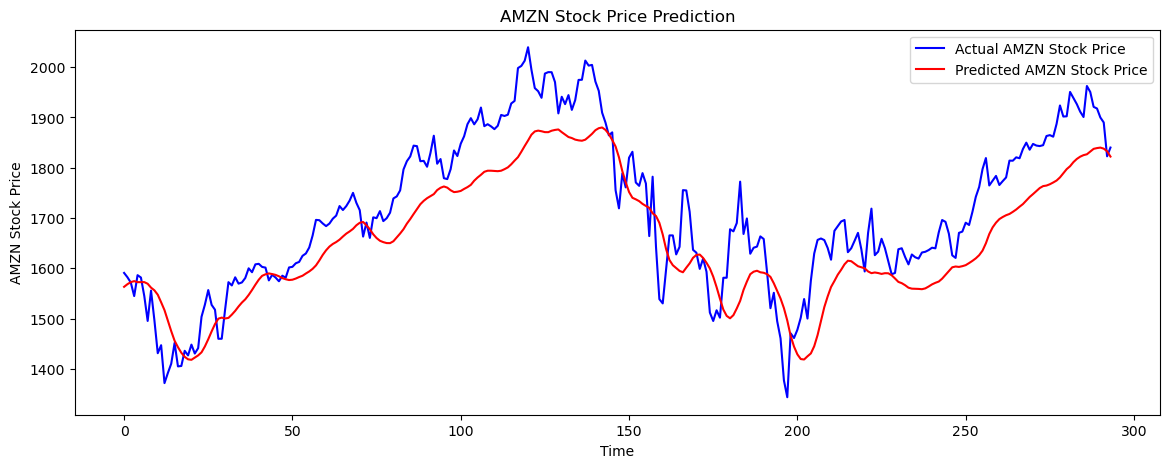

In [14]:
import matplotlib.pyplot as plt

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], len(data.columns) - 1))), axis=1))[:, 0]

# Inverse transform the actual values for comparison
actual_values = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(data.columns) - 1))), axis=1))[:, 0]

# Plot the actual vs predicted values
plt.figure(figsize=(14, 5))
plt.plot(actual_values, color='blue', label='Actual AMZN Stock Price')
plt.plot(predictions, color='red', label='Predicted AMZN Stock Price')
plt.title('AMZN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AMZN Stock Price')
plt.legend()
plt.show()